In [1]:
# Import Statements
#from utils import *
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import Dataset
from matplotlib.pyplot import cm

import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import numpy as np
import h5py

from vizz import visualize3D
#from utils import Logger
from toySphere import sphere
import random

torch.set_default_tensor_type('torch.DoubleTensor')


In [2]:

#utils
# Custom dataloader for 3D spheres dataset 
class ToySpheres(Dataset):

    def __init__(self, shape, seed, transform=None):
        random.seed(seed)
        self.data_dir = []
        self.dataShape = shape
        print('Creating training data...')
        for _ in range(shape[0]):
            s_x = random.randint(-shape[2]//2 + 2, shape[2]//2 - 2)
            s_y = random.randint(-shape[3]//2 + 2, shape[3]//2 - 2)
            s_z = random.randint(-shape[4]//2 + 2, shape[4]//2 - 2)
            s_r = random.uniform(1.1, 8.0)
            self.data_dir.append((s_x, s_y, s_z, s_r))
        print('Complete!')
        self.transform = transform

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        params = self.data_dir[idx]
        model = np.expand_dims(sphere(self.dataShape[2], self.dataShape[3], self.dataShape[4],
                                      params[0],
                                      params[1],
                                      params[2],
                                      params[3]), axis=0)
        if self.transform:
            model = self.transform(model)
        return torch.from_numpy(model)
    



#for one-hot encoding
def to_categorical(y, num_classes=None, dtype='float32'):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    # Example
    ```python
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    > labels
    array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many
    # columns as there are classes. The number of rows
    # stays the same.
    > to_categorical(labels)
    array([[ 1.,  0.,  0.],
           [ 0.,  0.,  1.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.],
           [ 1.,  0.,  0.]], dtype=float32)
    ```
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [3]:
# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 128
EMBEDDING_SIZE = (2, 2, 2)
NOISE_VAL = 0.2
LR = 0.001         # learning rate

Creating training data...
Complete!


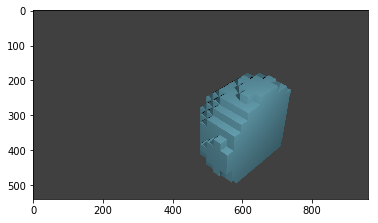

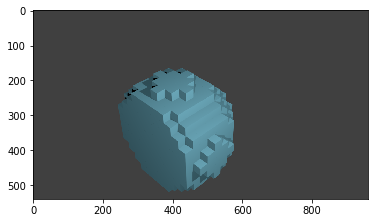

In [4]:
dataset = ToySpheres((6000, 1, 16, 16, 16), 1)

# Create loader with data, so that we can iterate over it
train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
# Num batches
num_batches = len(train_loader)

for index in range(2):
    test_sphere = np.squeeze(dataset[index].detach().numpy())
    visualize3D(test_sphere, title="sample" + str(index), thresh=0.1)
    plt.show()


In [ ]:
#Define AutoEncoder class

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels = 1, out_channels = 64, kernel_size = 5, stride = 1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # now 14x14x14
            nn.Conv3d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 12x12x12
            nn.MaxPool3d(2, stride=2),
            # 6x6x6
             nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 4x4x4
            nn.Conv3d(in_channels = 16, out_channels = 1, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 2x2x2
        )
        self.decoder = nn.Sequential(
#             nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
#             nn.LeakyReLU(0.2),
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.Conv3d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
#             nn.LeakyReLU(0.2),
            nn.Conv3d(in_channels = 1, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv3d(in_channels = 8, out_channels = 1, kernel_size = 3, stride = 1, padding = 1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Tanh(),
            #nn.Upsample(scale_factor=2, mode='nearest'),
            #nn.Tanh(),
            
            
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
#             nn.LeakyReLU(0.2),
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
#             nn.LeakyReLU(0.2),
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.Conv3d(in_channels = 8, out_channels = 1, kernel_size = 3, stride = 1, padding = 1),
#             nn.LeakyReLU(0.2),
#             nn.Tanh()
            
#             nn.ConvTranspose3d(32, 64, 3, stride=2),
#             nn.ReLU(True),
#             nn.ConvTranspose3d(64, 32, 3, stride=2),
#             nn.ReLU(True),
#             nn.ConvTranspose3d(32, 4, 3, stride=1),
#             nn.ReLU(True),
#             nn.ConvTranspose3d(4, 1, 4, stride=1),
#             nn.ReLU(True),
#             nn.Tanh()
        )
        
    def forward(self, val):
        print("val")
        print(val.shape)
        encoded = self.encoder(val)
        print("encode")
        print(encoded.shape)
        decoded = self.decoder(encoded)
        print("decode")
        print(decoded.shape)
        return encoded, decoded
        
    def encode(self, val):
        val = self.encoder(val)
        return val.cpu().data

    def decode(self, val):
        val = self.decoder(val)
        return val.cpu().data

In [ ]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
#loss_func = nn.BCELoss()
loss_func = nn.MSELoss()

0
val
torch.Size([100, 1, 16, 16, 16])
encode
torch.Size([100, 1, 2, 2, 2])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning:

nn.Upsampling is deprecated. Use nn.functional.interpolate instead.



decode
torch.Size([100, 1, 16, 16, 16])
decoded


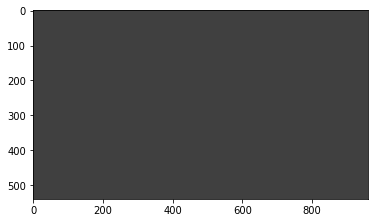

Epoch:  0 | train loss: 0.1004
1
val
torch.Size([100, 1, 16, 16, 16])
encode
torch.Size([100, 1, 2, 2, 2])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning:

nn.Upsampling is deprecated. Use nn.functional.interpolate instead.



decode
torch.Size([100, 1, 16, 16, 16])
decoded


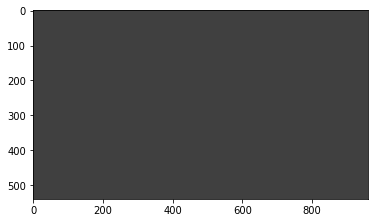

2
val
torch.Size([100, 1, 16, 16, 16])
encode
torch.Size([100, 1, 2, 2, 2])
decode
torch.Size([100, 1, 16, 16, 16])
decoded


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning:

nn.Upsampling is deprecated. Use nn.functional.interpolate instead.



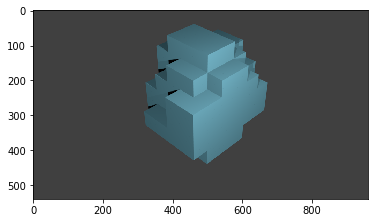

3
val
torch.Size([100, 1, 16, 16, 16])
encode
torch.Size([100, 1, 2, 2, 2])
decode
torch.Size([100, 1, 16, 16, 16])
decoded


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning:

nn.Upsampling is deprecated. Use nn.functional.interpolate instead.



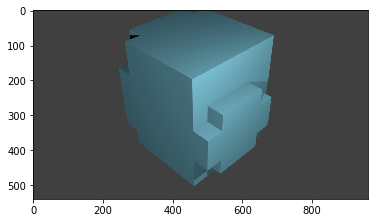

4
val
torch.Size([100, 1, 16, 16, 16])
encode
torch.Size([100, 1, 2, 2, 2])
decode
torch.Size([100, 1, 16, 16, 16])
decoded


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning:

nn.Upsampling is deprecated. Use nn.functional.interpolate instead.



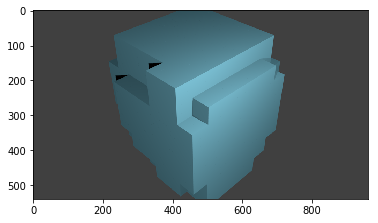

5
val
torch.Size([100, 1, 16, 16, 16])
encode
torch.Size([100, 1, 2, 2, 2])
decode
torch.Size([100, 1, 16, 16, 16])
decoded


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning:

nn.Upsampling is deprecated. Use nn.functional.interpolate instead.



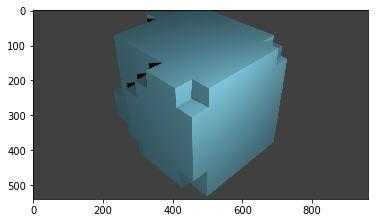

6
val
torch.Size([100, 1, 16, 16, 16])
encode
torch.Size([100, 1, 2, 2, 2])
decode
torch.Size([100, 1, 16, 16, 16])
decoded


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning:

nn.Upsampling is deprecated. Use nn.functional.interpolate instead.



In [ ]:
for epoch in range(EPOCH):
    for step, (x) in enumerate(train_loader):
        print(step)
        
        # batch x, shape (batch, 28, 28)
        b_x = x + NOISE_VAL * torch.rand_like(x) / (1.0 + NOISE_VAL) # Renormalize with added noise
#         print("bx")
#         print(b_x.shape)
        encoded, decoded = autoencoder(b_x)
        print("decoded")
        #print(decoded.detach()[0])
        test_sphere = np.squeeze(decoded.detach()[0].numpy())
        visualize3D(test_sphere, title="sample" + str(index), thresh=0.1)
        plt.show() 
        
        
        loss = loss_func(decoded, x)        # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())
#             test_sphere = np.squeeze(decoded.detach()[0].numpy())
#             visualize3D(test_sphere, title="decoded" + str(index), thresh=0.1)
#             plt.show()
#             visualize3D(np.squeeze(decoded[0].detach().numpy()),
#                         title="Test_0/e" + str(epoch),
#                         percentile=0.85,
#                         plot=True)
#             plt.show()
            # plotting decoded image (second row)
            #_, decoded_data = autoencoder(view_data)
#             decoded_data = np.reshape(decoded_data.data.numpy()[0], (4, 16, 16, 16))
#             s = visualize3D(decoded_data, color=(0, 1, 1), percentile=0.85)
#             s
#             # initialize figure
#             f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))

#             for i in range(N_TEST_IMG):
#                 a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
#                 a[1][i].clear()
#                 a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
#                 a[1][i].set_xticks(()); a[1][i].set_yticks(())
#             plt.draw(); plt.pause(0.05)